In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
# NOTE: make sure to build the op
filter_ops = tf.load_op_library('./filter_op/build/filter_op.so')

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import timeit

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/bagautdi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def compute_spatial(height, width):
    xs = tf.tile(tf.reshape(tf.range(0, width), [1, width, 1]), [height, 1, 1])
    ys = tf.tile(tf.reshape(tf.range(0, height), [height, 1, 1]), [1, width, 1])
    return tf.cast(tf.concat([xs, ys], 2), tf.float32)

def meanfield_op(unary, 
                 features_sp, features_bl, 
                 kernel_sp, kernel_bl, kernel_compat,
                 n_iters=10, step=None, norm_eps=1e-20, 
                 name='meanfield'):

    with tf.variable_scope(name):
        N = unary.get_shape()[0]

        norm_feed = tf.ones([N,1], dtype=tf.float32)

        # TODO: should we make a batch version?
        lattice_sp = filter_ops.permuto_init(features_sp)
        norm_sp = 1.0 / (norm_eps + filter_ops.permuto_compute(norm_feed, *lattice_sp))

        lattice_bl = filter_ops.permuto_init(features_bl)
        norm_bl = 1.0 / (norm_eps + filter_ops.permuto_compute(norm_feed, *lattice_bl))

        nats = [unary]
        
        probs = [slim.softmax(unary)]

        for it in range(n_iters):
            prob = probs[-1]
            msg_sp = tf.matmul(filter_ops.permuto_compute(prob, *lattice_sp) * norm_sp, 
                               kernel_sp)
            msg_bl = tf.matmul(filter_ops.permuto_compute(prob, *lattice_bl) * norm_bl, 
                               kernel_bl)
            pairwise = tf.matmul(msg_sp + msg_bl, kernel_compat)

            if step is None:
                nats += [unary - pairwise]
            else:
                nats += [(1.0 - step) * nats[-1] + step * (unary - pairwise)]
            probs += [slim.softmax(nats[-1])]
        return probs


In [3]:
# loading inputs
in_unaries = np.load('data/input.unaries.npy')
in_unaries = np.squeeze(in_unaries).transpose((1,2,0))
in_rgb = np.load('data/input.bgr.npy')[:,:,::-1]

OH, OW, NC = in_unaries.shape  

In [4]:
# building the inference
with tf.variable_scope('inference'):
    height, width, num_classes = OH, OW, NC

    num_bboxes = tf.placeholder(tf.int32, [1], name='num_bboxes')
    # TODO: the last dimension can change actually
    unary = tf.placeholder(tf.float32, [height*width, num_classes], name='unary')
    rgb = tf.placeholder(tf.float32, [height, width, 3], name='rgb')

    # various parameters
    sxy_sp = tf.placeholder(tf.float32, [])
    sxy_bl = tf.placeholder(tf.float32, [])
    srgb_bl = tf.placeholder(tf.float32, [])

    # TODO: the kernels
    kernel_sp = 1.0 * tf.diag(tf.ones(num_bboxes, dtype=np.float32))
    kernel_bl = 3.0 * tf.diag(tf.ones(num_bboxes, dtype=np.float32))
    kernel_compat = -1.0 * tf.diag(tf.ones(num_bboxes, dtype=np.float32))

    # computing features
    features_sp = tf.reshape(compute_spatial(height, width) / sxy_sp, 
                             [height*width, 2])
    features_bl = tf.reshape(tf.concat(axis=2, 
                                       values=[compute_spatial(height, width) / sxy_bl,
                                         rgb / srgb_bl]),
                           [height*width, 2+3])

    probs = meanfield_op(unary, 
                       features_sp, features_bl, 
                       kernel_sp, kernel_bl, kernel_compat, 
                       n_iters=20)

elapsed: 3.325383199378848


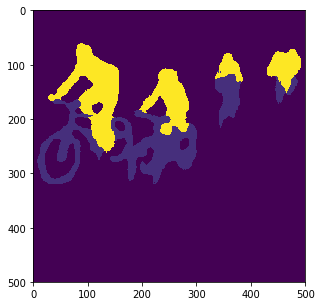

In [5]:
with tf.Session() as sess:
    feed_dict = {
        unary : in_unaries.reshape((OH*OW, NC)),
        rgb : in_rgb,
        num_bboxes : [NC],
        sxy_sp : 1.0,
        sxy_bl : 3.0,
        srgb_bl : 60.0
    }

    start_time = timeit.default_timer()
    _probs = sess.run(probs, feed_dict)[-1].reshape((OH,OW,NC))
    print(f'elapsed: {timeit.default_timer() - start_time}')
    mask = np.argmax(_probs, axis=2)
    
plt.figure(figsize=(5, 5))
plt.imshow(mask)  
    